# Reduce PDS data

To _reduce_ PDS may be different across different datasets/product-types

Here, we are going to work with MRO/HiRISE data.

In [1]:
dataset = 'hirise'

In [2]:
from gpt.helpers import collection

from importlib import reload
reload(collection)

<module 'gpt.helpers.collection' from '/mnt/data/repos/GMAP/gpt/gpt/helpers/collection.py'>

In [3]:
ls ../01_search-download_from_ode-pds/

01_search_data_products.ipynb    download_ctx.geojson     search_ctx.geojson
02_download_data_products.ipynb  download_hirise.geojson  search_hirise.geojson
data@                            download_hrsc.geojson    search_hrsc.geojson


In [4]:
from pathlib import Path

db_path = Path(f'../01_search-download_from_ode-pds/download_{dataset}.geojson')

archive = collection.from_geojson(db_path.as_posix())

In [5]:
archive

                                            geometry BB_georeferenced  \
0  POLYGON ((0.07970 -0.23430, -0.01100 -0.24530,...             True   
1  POLYGON ((0.07970 -0.23430, -0.01100 -0.24530,...             True   
2  POLYGON ((-0.02200 0.00450, -0.11300 -0.00660,...             True   
3  POLYGON ((-0.02200 0.00450, -0.11300 -0.00660,...             True   
4  POLYGON ((0.06460 -0.14320, -0.03000 -0.15470,...             True   
5  POLYGON ((0.06460 -0.14320, -0.03000 -0.15470,...             True   

  Center_georeferenced Center_latitude Center_longitude           Comment  \
0                 True         -0.0145           0.0069    Center of Mars   
1                 True         -0.0145           0.0069    Center of Mars   
2                 True          0.1009         359.9205  Meridiani Planum   
3                 True          0.1009         359.9205  Meridiani Planum   
4                 True         -0.0033           0.0006    Center of Mars   
5                 True    

## Data and metadata processing

We have in our data store those four product files:
```
0  ./data/MRO/HIRISE/RDRV11/PSP_007361_1800_RED.JP2  
1  ./data/MRO/HIRISE/RDRV11/PSP_007361_1800_RED.LBL  
2  ./data/MRO/HIRISE/RDRV11/ESP_023817_1800_RED.JP2  
3  ./data/MRO/HIRISE/RDRV11/ESP_023817_1800_RED.LBL  
4  ./data/MRO/HIRISE/RDRV11/ESP_041909_1800_RED.JP2  
5  ./data/MRO/HIRISE/RDRV11/ESP_041909_1800_RED.LBL  
```
corresponding to image/data and header/metadata files for two data products: `h1998_0000_nd3` and `ha482_0000_nd3`.

Images are in [JPEG2000]() format, while the headers are in [PDS LABEL]() format.

We want to convert those JP2 images into geotiff and just check what PDS LABEL files look like.

### JP2 to GeoTIFF with `rasterio`

Rasterio, different from GDAL, it is a Python library that handles _most_ of the work we are used to do with GDAL.
Rasterio uses part of the engine/libraries provided by GDAL.

In this notebook, we're doing the convertion from JPEG2000 to GeoTIFF with Rasterio.
For one reason, educative, to show how it is done with Rasterio.

Because the HiRISE images are considerably large, we will also apply a _rescaling_ in the size of the images.
The Python code -- Rasterio -- is not the most simple but it also reveals a lot of details that we have to handle when dealing with complex data like geospatial images.

The function below `to_tiff()` (with support for simple scaling measures inside `scale_transform()` does everything for us.

The equivalent for what `to_tiff` is doing with `gdal_translate` would be:
```bash
$ gdal_translate -r bilinear -outsize 50% 50% -of GTiff -co COMPRESS=LZW input.jp2 output.tif
```

In [6]:
def to_tiff(filename_in, filename_out, format_in='JP2OpenJPEG', scale_factor=0.5):
    """
    For accepted formats (in): https://gdal.org/drivers/raster/index.html
    """
    import rasterio
    from rasterio.enums import Resampling

    with rasterio.open(filename_in, 'r', driver=format_in) as src:
        # Get a copy of the source dataset's profile. Thus our
        # destination dataset will have the same dimensions,
        # number of bands, data type, and georeferencing as the
        # source dataset.
        kwargs = src.profile.copy()
        kwargs['driver'] = 'GTiff'
        kwargs['compress'] = 'LZW'

        transform, width, height = scale_transform(src.transform,
                                        src.width, src.height,
                                        scale_factor=scale_factor)
        
        # resample data to target shape
        data = src.read(
            out_shape=(src.count, height, width),
            resampling=Resampling.bilinear
        )

        kwargs.update({
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with rasterio.open(filename_out, 'w', **kwargs) as dst:
            for i, band in enumerate(data, 1):
                dst.write(band, i)

    return filename_out


def scale_transform(transform_src, width_src, height_src, scale_factor=0.5):
    src_transform = transform_src
    src_height = height_src
    src_width = width_src

    # compute "dst" sizes
    height = int(src_height * scale_factor)
    width = int(src_width * scale_factor)

    # scale image transform
    transform = src_transform * src_transform.scale(
        (src_width / width),
        (src_height / height)
    )

    return (transform, width, height)


In [7]:
def _to_tif(pid, path):
    return to_tiff(f'./data/MRO/HIRISE/RDRV11/{pid}.JP2', f'{path}/{pid}.tif')

In [8]:
import os

path_out = './data/MRO/HIRISE/Reduced'
files_out = []

os.makedirs(path_out, exist_ok=True)

In [9]:
pid = 'ESP_023817_1800_RED'

# to_tiff(f'./data/MRO/HIRISE/RDRV11/{pid}.JP2', f'{path}/{pid}.tif')

out = _to_tif(pid, path_out)
files_out.append(out)

In [10]:
pid = 'ESP_041909_1800_RED'

out = _to_tif(pid, path_out)
files_out.append(out)

In [11]:
pid = 'PSP_007361_1800_RED'

out = _to_tif(pid, path_out)
files_out.append(out)

In [13]:
%matplotlib inline

def plot(files):
    import rasterio
    from matplotlib import pyplot as plt
    from rasterio.plot import show
    
    n_files = len(files)
    fig, axs = plt.subplots(1, n_files, figsize=(24,12))
    for i, fname in enumerate(files):
        title = fname.split('/')[-1].split('.')[:-1]
        img = rasterio.open(fname)
        show((img, 1), ax=axs[i], cmap='pink', title=title)
        

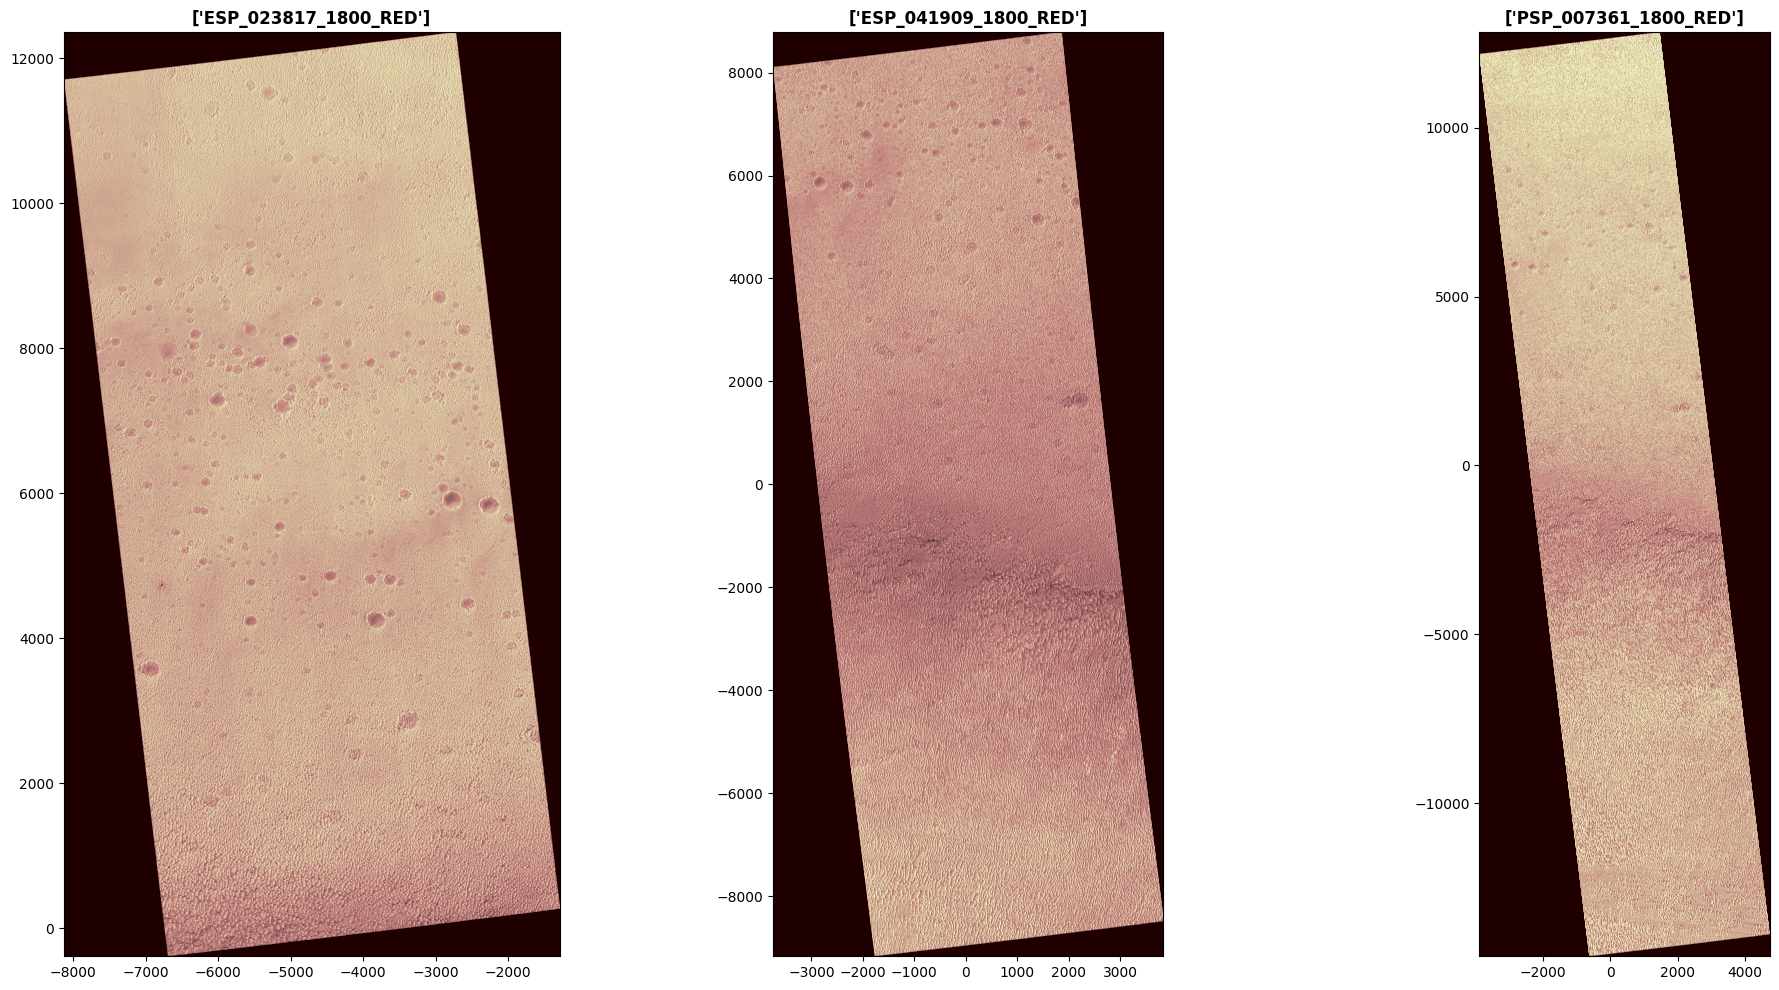

In [14]:
plot(files_out)